In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cof import COF
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import pydotplus
from sklearn import tree
from IPython.display import Image

In [35]:
#importo il train e test encoded
df_train = pd.read_csv('df_train_mod2.csv')
df_test = pd.read_csv('df_test_mod2.csv')

In [36]:
y_train = df_train['emotion']
y_test = df_test['emotion']

In [37]:
df_train.drop(columns=['emotion'],inplace=True)

In [38]:
df_test.drop(columns=['emotion'],inplace=True)

In [39]:
df_train

frame_count       sum       std       q25  q50       q75        kur  \
0          158558  0.145081  0.004001 -0.000031  0.0  0.000000  15.028520   
1          160160  0.114319  0.004283 -0.000031  0.0  0.000000  16.488415   
2          156956  0.149963  0.005084  0.000000  0.0  0.000000  17.035218   
3          152152  0.139618  0.004886 -0.000031  0.0  0.000000  21.824521   
4          169769  0.137665  0.002956 -0.000031  0.0  0.000000  13.236022   
...           ...       ...       ...       ...  ...       ...        ...   
1797       168168 -0.154480  0.005399  0.000000  0.0  0.000031   6.504521   
1798       174575 -0.139679  0.008788 -0.000031  0.0  0.000031   9.706586   
1799       169770 -0.210968  0.009933  0.000000  0.0  0.000031   5.874582   
1800       185786 -0.085876  0.012221 -0.000031  0.0  0.000092   4.482247   
1801       174574 -0.195312  0.009659 -0.000031  0.0  0.000092   4.534792   

          skew  lag1_sum  lag1_std  ...  stft_min_w4  stft_q75_w4  \
0     0.904033  0.000000  0.000511  ...     0.000000     0.896606   
1     1.001578  0.000000  0.000540  ...     0.270133     0.874713   
2     1.269509 -0.000061  0.000873  ...     0.000000     0.899156   
3     1.799676 -0.000031  0.000907  ...     0.205616     0.886474   
4     0.619367 -0.000031  0.000397  ...     0.177847     0.878014   
...        ...       ...       ...  ...          ...          ...   
1797 -0.437772  0.000000  0.001333  ...     0.000000     0.893268   
1798 -0.079604  0.000000  0.002307  ...     0.000000     0.900089   
1799 -0.026582  0.000000  0.001970  ...     0.000000     0.891486   
1800 -0.106998  0.000000  0.004435  ...     0.000000     0.869563   
1801 -0.350653  0.000000  0.004581  ...     0.000000     0.856638   

      stft_q95_w4  stft_kur_w4  stft_skew_w4  vocal_channel  \
0             1.0     6.742190     -1.706215              1   
1             1.0    -0.700420     -0.201495              1   
2             1.0     1.688986     -1.024773              1   
3             1.0    -0.594111     -0.412871              1   
4             1.0     0.126535     -0.620782              1   
...           ...          ...           ...            ...   
1797          1.0     0.262900     -1.051814              1   
1798          1.0    -0.857759     -0.608583              1   
1799          1.0    -0.656632     -0.586954              1   
1800          1.0    -0.499022     -0.849045              1   
1801          1.0    -0.962943     -0.276517              1   

      emotional_intensity  statement  repetition  sex  
0                       0          1           0    1  
1                       0          1           1    1  
2                       0          0           0    1  
3                       0          0           1    1  
4                       0          1           0    1  
...                   ...        ...         ...  ...  
1797                    0          0           1    0  
1798                    1          1           0    0  
1799                    1          1           1    0  
1800                    1          0           0    0  
1801                    1          0           1    0  

[1802 rows x 237 columns]

In [40]:
columns_to_scale_train = df_train.iloc[:, :-5]
columns_to_scale_test = df_test.iloc[:, :-5]


# Extract the columns to be kept as they are
columns_to_keep_train = df_train.iloc[:, -5:]
columns_to_keep_test = df_test.iloc[:, -5:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the columns to be scaled
scaler.fit(columns_to_scale_train)
train_scaled = scaler.transform(columns_to_scale_train)
test_scaled = scaler.transform(columns_to_scale_test)


# Concatenate the scaled columns and the columns to be kept
df_train = pd.concat([pd.DataFrame(train_scaled, columns=columns_to_scale_train.columns), columns_to_keep_train], axis=1)
df_test = pd.concat([pd.DataFrame(test_scaled, columns=columns_to_scale_test.columns), columns_to_keep_test], axis=1)


In [41]:
x_train = df_train.values
x_test = df_test.values

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold


In [24]:
#Faccio la grid search per trovare i migliori parametri di SVM, visto che quelli che sono sul report come corretti non sono testati sul train giusto. 
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma' : np.logspace(-3, 3, num=7),
}

clf = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=42),
                         n_iter=10, verbose=10)



In [25]:
clf.fit(x_train, y_train)

print()
print('best:')
print(clf.best_estimator_)
print(clf.best_score_)

#best:
#SVC(C=0.01, gamma=0.1, kernel='poly')
#0.6195370883348723

Fitting 50 folds for each of 10 candidates, totalling 500 fits
[CV 1/50; 1/10] START C=100, degree=3, gamma=1000.0, kernel=sigmoid.............
[CV 1/50; 1/10] END C=100, degree=3, gamma=1000.0, kernel=sigmoid;, score=0.233 total time=   1.6s
[CV 2/50; 1/10] START C=100, degree=3, gamma=1000.0, kernel=sigmoid.............
[CV 2/50; 1/10] END C=100, degree=3, gamma=1000.0, kernel=sigmoid;, score=0.208 total time=   0.2s
[CV 3/50; 1/10] START C=100, degree=3, gamma=1000.0, kernel=sigmoid.............
[CV 3/50; 1/10] END C=100, degree=3, gamma=1000.0, kernel=sigmoid;, score=0.233 total time=   0.2s
[CV 4/50; 1/10] START C=100, degree=3, gamma=1000.0, kernel=sigmoid.............
[CV 4/50; 1/10] END C=100, degree=3, gamma=1000.0, kernel=sigmoid;, score=0.189 total time=   0.2s
[CV 5/50; 1/10] START C=100, degree=3, gamma=1000.0, kernel=sigmoid.............
[CV 5/50; 1/10] END C=100, degree=3, gamma=1000.0, kernel=sigmoid;, score=0.208 total time=   0.2s
[CV 6/50; 1/10] START C=100, degree=3

In [ ]:
#Provo a testarlo sul test giusto per vedere se funziona 

              precision    recall  f1-score   support

           0       0.47      0.68      0.56        96
           1       0.48      0.46      0.47        96
           2       0.48      0.46      0.47        48
           3       0.38      0.41      0.39        96
           4       0.36      0.41      0.38        96
           5       0.29      0.27      0.28        48
           6       0.40      0.23      0.29        96
           7       0.39      0.31      0.35        48

    accuracy                           0.42       624
   macro avg       0.41      0.40      0.40       624
weighted avg       0.41      0.42      0.41       624



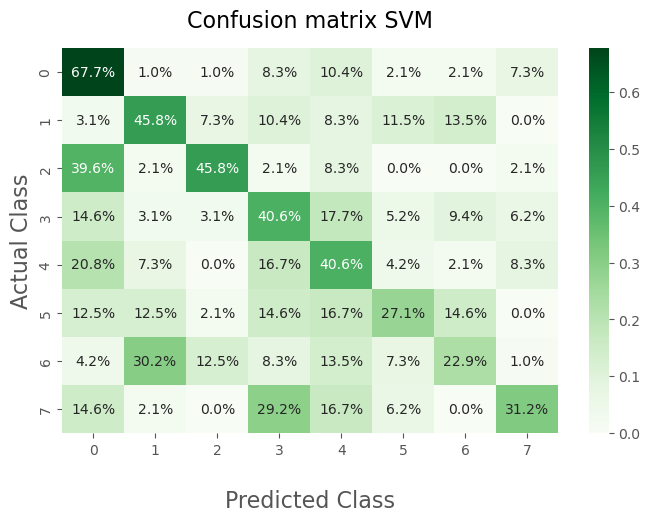

In [43]:
svm = SVC(C=0.01, gamma=0.1, kernel='poly')
svm_clf = svm.fit(x_train, y_train)
em_predict = svm_clf.predict(x_test)

print(classification_report(y_test, em_predict))

cm = confusion_matrix(y_test, em_predict, normalize='true')

plt.figure(figsize = (8,5))
plt.style.use('ggplot')
sns.heatmap(cm, annot=True, cmap="Greens", xticklabels=svm.classes_, yticklabels=svm.classes_ , fmt='.1%') #cmap="PiYG
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM', fontsize = 16, pad = 15)
plt.show()

#ottengo accuracy del 0.42

In [ ]:
#MIGLIOR SVM: #SVC(C=0.01, gamma=0.1, kernel='poly')

<h2>EXPLAINABILITY</h2>

<H4>TREPAN</H4>
Global, model agnostic

In [44]:
bb = SVC(C=0.01, gamma=0.1, kernel='poly',probability=True) #best svm
bb.fit(x_train, y_train)

SVC(C=0.01, gamma=0.1, kernel='poly', probability=True)

In [45]:
# just calling the predict or the predict proba of the bb
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [46]:
y_pred = bb_predict(x_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred, average='macro'))

Accuracy 0.415
F1-measure 0.398


In [123]:
#è un'approssimazione di TREPAN (perchè TreeSurrogate potrebbe non funzionare)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

y_pred_train = bb_predict(x_train)  # train! 
# # IL MODELLO E' TRAINATO SULLA PREDIZIONE DELLA BB !!!!

In [133]:
explainer = DecisionTreeClassifier(max_depth=3)  #max_depth = 4 perchè poi lo voglio spiegare - sarà il gloabal explainer della mia bb svm
explainer.fit(x_train, y_pred_train)   # uso come target variable the prediction on the training, NON the ground truth!

DecisionTreeClassifier(max_depth=3)

In [134]:
#devo recuperare i nomi delle feature del train e devono stare in una lista
df_train.columns


Index(['frame_count', 'sum', 'std', 'q25', 'q50', 'q75', 'kur', 'skew',
       'lag1_sum', 'lag1_std',
       ...
       'stft_min_w4', 'stft_q75_w4', 'stft_q95_w4', 'stft_kur_w4',
       'stft_skew_w4', 'vocal_channel', 'emotional_intensity', 'statement',
       'repetition', 'sex'],
      dtype='object', length=237)

In [135]:
bb.classes_

array([0, 1, 2, 3, 4, 5, 6, 7])

In [136]:
class_names_mapping = {
    0: 'angry',
    1: 'calm',
    2: 'disgust',
    3: 'fearful',
    4: 'happy',
    5: 'neutral',
    6: 'sad',
    7: 'surprised'
}

# Map numerical values to class names
class_names = [class_names_mapping[class_value] for class_value in bb.classes_]


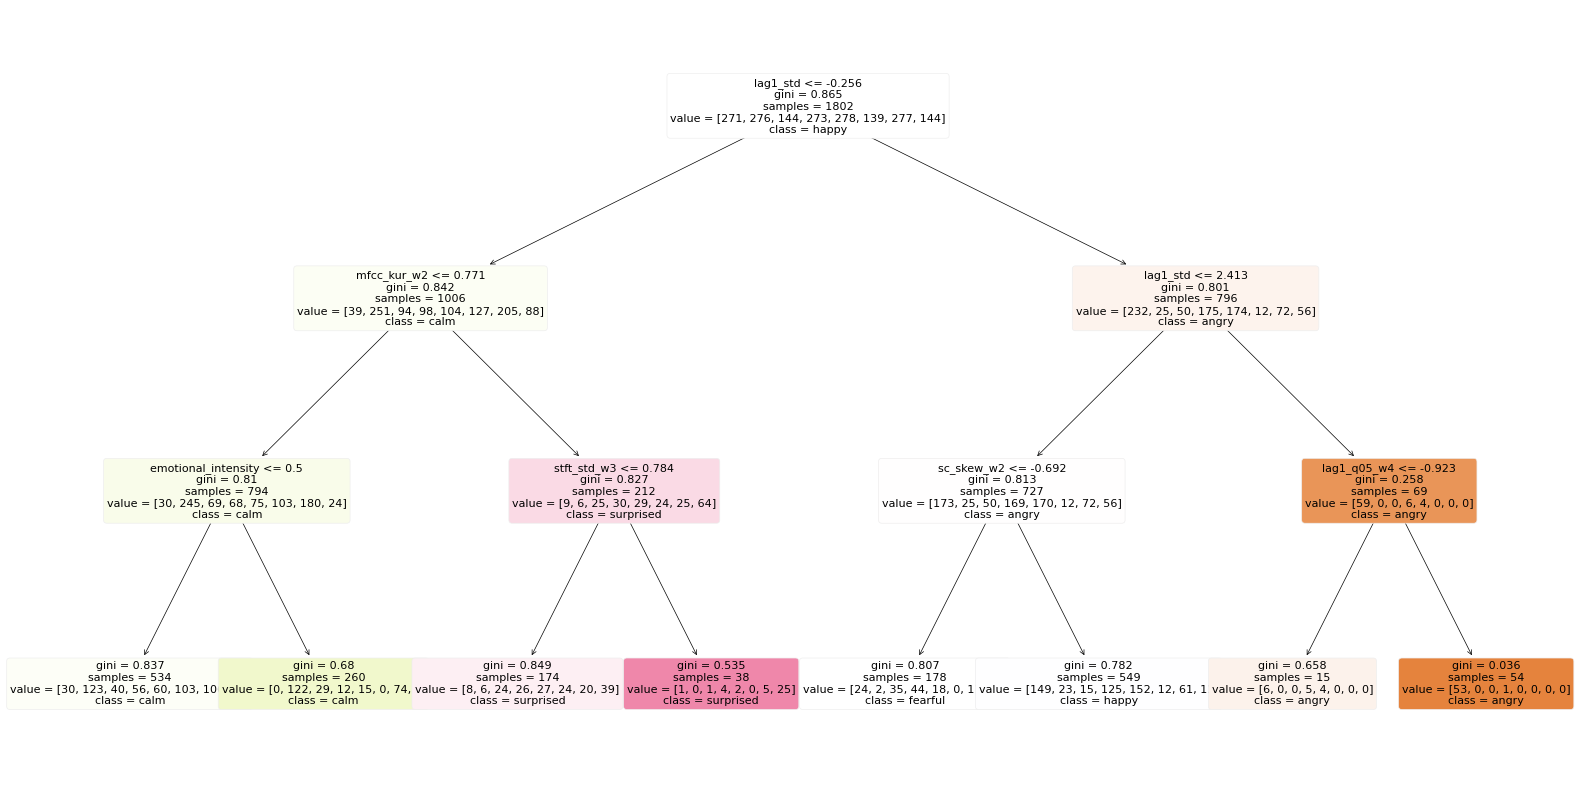

In [139]:
feature_names = list(df_train.columns)

plt.figure(figsize=(20, 10))
plot_tree(explainer, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          rounded=True,
          fontsize=8,
          max_depth=3)  
plt.show()

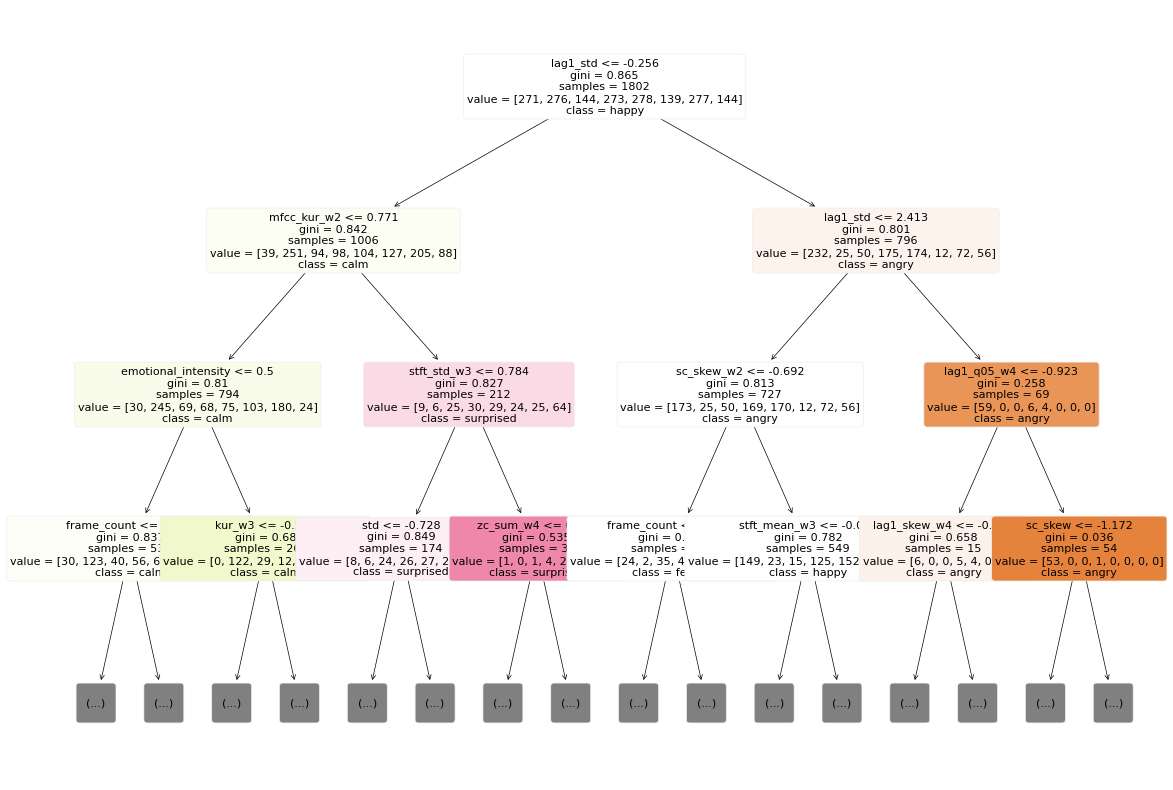

In [52]:
#provo a plottare con profondità 3, ma non si leggono
feature_names = list(df_train.columns)

plt.figure(figsize=(14, 10))
plot_tree(explainer, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          rounded=True,
          fontsize=8,
          max_depth=3)  
plt.show()

In [53]:
from sklearn.tree import _tree

In [54]:
#stampo le regole scritte, nel caso potesse servire
def tree_to_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left = recurse(tree_.children_left[node])
            right = recurse(tree_.children_right[node])
            return f"{name} <= {threshold:.2f}\n{left}\n{right}"
        else:
            class_idx = np.argmax(tree_.value[node])
            return f"Class: {class_names[class_idx]}"

    return recurse(0)

rules = tree_to_rules(explainer, feature_names, class_names)
print(rules)

lag1_std <= -0.26
mfcc_kur_w2 <= 0.77
emotional_intensity <= 0.50
frame_count <= 1.38
Class: neutral
Class: sad
kur_w3 <= -0.54
Class: calm
Class: sad
stft_std_w3 <= 0.78
std <= -0.73
Class: neutral
Class: surprised
zc_sum_w4 <= 0.52
Class: surprised
Class: sad
lag1_std <= 2.41
sc_skew_w2 <= -0.69
frame_count <= -0.22
Class: fearful
Class: disgust
stft_mean_w3 <= -0.00
Class: happy
Class: angry
lag1_q05_w4 <= -0.92
lag1_skew_w4 <= -0.09
Class: fearful
Class: angry
sc_skew <= -1.17
Class: fearful
Class: angry


In [76]:
#alleno con max_depth 2, che è quello che riesco a plottare

explainer2 = DecisionTreeClassifier(max_depth=2)  #max_depth = 2 perchè poi lo voglio spiegare - sarà il gloabal explainer della mia bb svm
explainer2.fit(x_train, y_pred_train) 

DecisionTreeClassifier(max_depth=2)

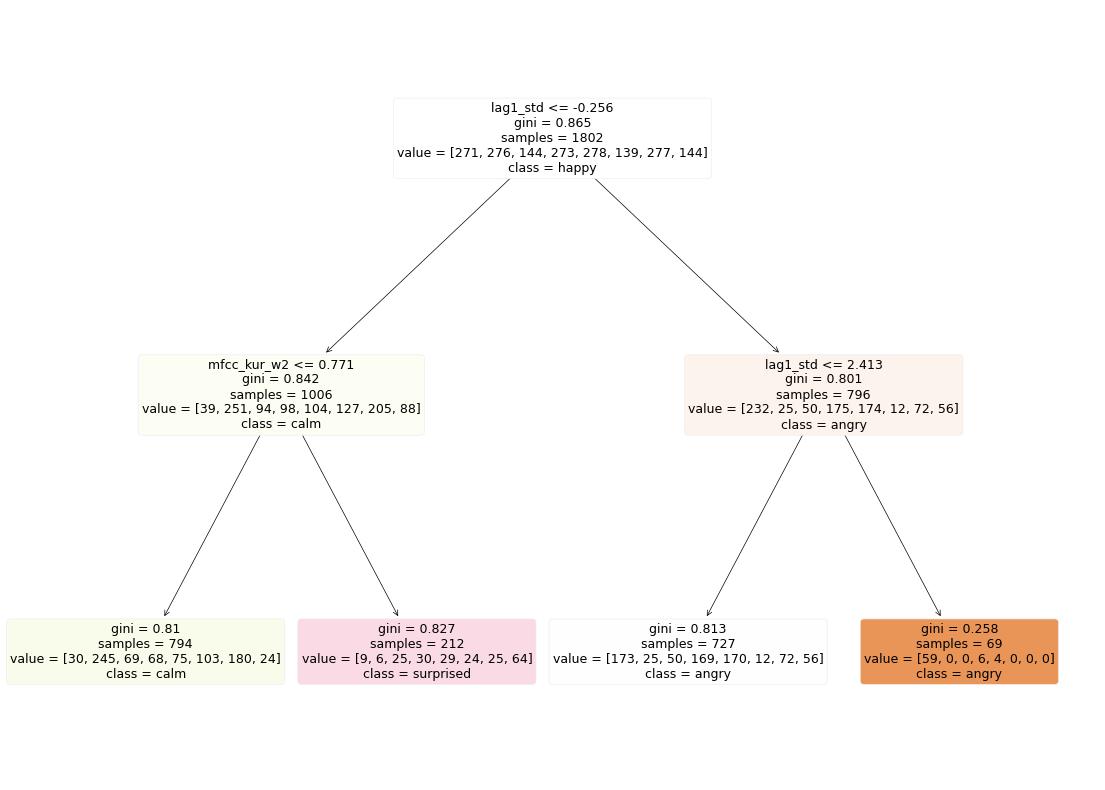

In [77]:
feature_names = list(df_train.columns)

plt.figure(figsize=(14, 10))
plot_tree(explainer2, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          rounded=True,
          fontsize=9,
          max_depth=3)  
plt.show()

<h4>LIME</h4>
LOCAL e Model agnostic

In [79]:
#!pip install lime

In [80]:
from lime.lime_tabular import LimeTabularExplainer

In [81]:
#devo cercare di spiegare un record del test, prendo il 42 a caso
x=x_test[42]

In [ ]:
class_names_mapping = {
    0: 'angry',
    1: 'calm',
    2: 'disgust',
    3: 'fearful',
    4: 'happy',
    5: 'neutral',
    6: 'sad',
    7: 'surprised'
}

# Map numerical values to class names
class_names = [class_names_mapping[class_value] for class_value in bb.classes_]

In [83]:
#bb è la SVM migliore
bb_outcome = bb_predict(x.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
 #bb_outcome_str = class_names[bb_outcome]

print('bb(x) = { %s }' % class_names_mapping[bb_outcome])   # bb(x) = { fearful }  
print('')

bb(x) = { fearful }



In [84]:
lime_explainer = LimeTabularExplainer(x_test,  # assuming we dont have access to the training, come se il bb fosse creato sul training da qualcunaltro e io non ho quel training ho solo il test
                                      feature_names=feature_names,
                                      class_names=class_names, discretize_continuous=False)

In [85]:
exp = lime_explainer.explain_instance(x, bb_predict_proba, labels=[0, 1, 2, 3, 4, 5, 6, 7])  
# passo anche bb_predict_proba, perchè lime usa la prdiction probability invece che solo la prediction 

In [87]:
class_names_mapping[y_test[42]]
#metto questo class_names_mapping per ottenere il nome dell'emotion e non il numero

'fearful'

In [88]:
exp.local_exp  # accessing the internals of the explanation

# feature 233 is the most important with a negative contribution of 0.010718832500906671
# restituisce una spiegazione locale per la previsione del modello su un'istanza di dati specifica.

{0: [(233, -0.010718832500906671),
  (9, 0.006817433013705622),
  (119, 0.006619217875207245),
  (127, 0.006040205320306667),
  (26, 0.004799137988000273),
  (147, 0.004613313690246783),
  (223, -0.003876298332861078),
  (170, -0.003363537076068848),
  (6, 0.002887369167922255),
  (186, -0.0006643819970820015)],
 1: [(17, -0.002051582666767098),
  (115, -0.0019295947877009854),
  (18, -0.001881589905883903),
  (9, -0.0017041200408273462),
  (233, 0.001692191848618791),
  (147, -0.0016082921305627662),
  (7, -0.0014976642056351165),
  (26, -0.0014867246383359635),
  (126, -0.0012668275859269971),
  (158, -0.000850881105758936)],
 2: [(232, 0.0024688424259322285),
  (233, 0.0017405467598496614),
  (19, 0.0017139645965504947),
  (178, 0.0016932661472558932),
  (164, 0.0014468818550912707),
  (113, 0.001361547296313081),
  (158, 0.001276650827337806),
  (172, -0.0010609596028486926),
  (170, -0.000884470723242438),
  (173, -0.0008681321259299796)],
 3: [(19, -0.005362362340911612),
  (223,

In [89]:
exp.show_in_notebook()
#Non sono particolarmente significativi, perchè molto piccoli. Sicuramente può essere utile quella tabella finale

PROVA ULTERIORE, VEDIAMO SE POI METTERLA: <BR>
Anche se non usato come task di classificazione precedentemente, proviamo a vedere se ad esempio LIME è più efficiente per quanto riguarda una classificazione binaria. Quindi vado a ridefinire la x e la y e provo a predirre Maschio Femmina <br>
<br>
Non viene una roba chissà quanto bella/ interessante quindi anche no

In [90]:
df_train2 = pd.read_csv('x_train.csv')
df_test2 = pd.read_csv('x_test.csv')
y_train2 = df_train2['sex']
y_test2 = df_test2['sex']
df_train2.drop(columns=['sex'],inplace=True)
df_test2.drop(columns=['sex'],inplace=True)
x_train2 = df_train2.values
x_test2 = df_test2.values

In [91]:
scaler = StandardScaler()
scaler.fit(x_train2)
x_train2 = scaler.transform(x_train2)
x_test2 = scaler.transform(x_test2)

In [92]:
#Faccio la grid search per trovare i migliori parametri di SVM, visto che quelli che sono sul report come corretti non sono testati sul train giusto. 
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma' : np.logspace(-3, 3, num=7),
}

clf2 = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=42),
                         n_iter=10, verbose=10)

In [93]:
clf2.fit(x_train2, y_train2)

print()
print('best:')
print(clf2.best_estimator_)
print(clf2.best_score_)

#best:
#SVC(C=0.1, degree=5, gamma=0.001, kernel='sigmoid')
#0.9314110495537089

Fitting 50 folds for each of 10 candidates, totalling 500 fits
[CV 1/50; 1/10] START C=0.001, degree=2, gamma=0.1, kernel=sigmoid..............
[CV 1/50; 1/10] END C=0.001, degree=2, gamma=0.1, kernel=sigmoid;, score=0.886 total time=   0.3s
[CV 2/50; 1/10] START C=0.001, degree=2, gamma=0.1, kernel=sigmoid..............
[CV 2/50; 1/10] END C=0.001, degree=2, gamma=0.1, kernel=sigmoid;, score=0.900 total time=   0.3s
[CV 3/50; 1/10] START C=0.001, degree=2, gamma=0.1, kernel=sigmoid..............
[CV 3/50; 1/10] END C=0.001, degree=2, gamma=0.1, kernel=sigmoid;, score=0.883 total time=   0.3s
[CV 4/50; 1/10] START C=0.001, degree=2, gamma=0.1, kernel=sigmoid..............
[CV 4/50; 1/10] END C=0.001, degree=2, gamma=0.1, kernel=sigmoid;, score=0.883 total time=   0.3s
[CV 5/50; 1/10] START C=0.001, degree=2, gamma=0.1, kernel=sigmoid..............
[CV 5/50; 1/10] END C=0.001, degree=2, gamma=0.1, kernel=sigmoid;, score=0.906 total time=   0.3s
[CV 6/50; 1/10] START C=0.001, degree=2, g

In [94]:
bb2 = SVC(C=0.1, gamma=0.001, kernel='sigmoid',degree=5, probability=True) #best svm
bb2.fit(x_train2, y_train2)

SVC(C=0.1, degree=5, gamma=0.001, kernel='sigmoid', probability=True)

In [95]:
y_pred2 = bb2.predict(x_test2)

print('Accuracy %.3f' % accuracy_score(y_test2, y_pred2))
print('F1-measure %.3f' % f1_score(y_test2, y_pred2, average='macro'))

Accuracy 0.942
F1-measure 0.942


In [111]:
y_pred_train2 = bb2.predict(x_train2)  # train! 

In [112]:
explainerbin = DecisionTreeClassifier(max_depth=4)  #max_depth = 4 perchè poi lo voglio spiegare - sarà il gloabal explainer della mia bb svm
explainerbin.fit(x_train2, y_pred_train2) 

DecisionTreeClassifier(max_depth=4)

In [120]:
x2=x_test2[1]

In [121]:
class_map_sex={0:'Female',1:'Male'}

#bb è la SVM migliore
bb2_outcome = bb2.predict(x2.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
 #bb_outcome_str = class_names[bb_outcome]

print('bb(x) = { %s }' % class_map_sex[bb2_outcome])   # Female:0, Male:1
print('') #bb(x) = { 0 } - female

bb(x) = { Male }



In [122]:
class_names_sex = [class_map_sex[class_value] for class_value in bb2.classes_]

In [123]:
feature_names2=list(df_train2.columns)


In [124]:
lime_explainer2 = LimeTabularExplainer(x_test2,  # assuming we dont have access to the training, come se il bb fosse creato sul training da qualcunaltro e io non ho quel training ho solo il test
                                      feature_names=feature_names2,
                                      class_names=class_names_sex, discretize_continuous=False)

In [125]:
exp2 = lime_explainer2.explain_instance(x, bb2.predict_proba, labels=[0, 1])  


In [127]:
class_map_sex[y_test2[1]]


'Male'

In [128]:
exp2.local_exp

{0: [(25, -0.036224089336682724),
  (140, -0.031788772897871),
  (178, -0.03169420338240031),
  (116, -0.031561479848695194),
  (125, -0.03132056105118101),
  (115, -0.029192462514405475),
  (118, -0.02575236176450677),
  (73, -0.020863187418189922),
  (164, -0.020348721745074197),
  (26, -0.01580640846462225)],
 1: [(25, 0.03622408933668271),
  (140, 0.031788772897871014),
  (178, 0.0316942033824003),
  (116, 0.031561479848695215),
  (125, 0.03132056105118101),
  (115, 0.029192462514405486),
  (118, 0.025752361764506765),
  (73, 0.020863187418189922),
  (164, 0.0203487217450742),
  (26, 0.015806408464622255)]}

In [129]:
exp2.show_in_notebook()


<h4>SHAP SUI CENTROIDI</h4>

In [130]:
!pip install shap

In [132]:
import shap
shap.initjs()

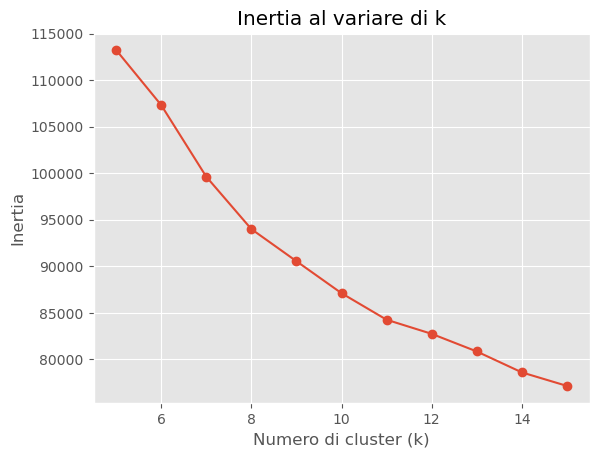

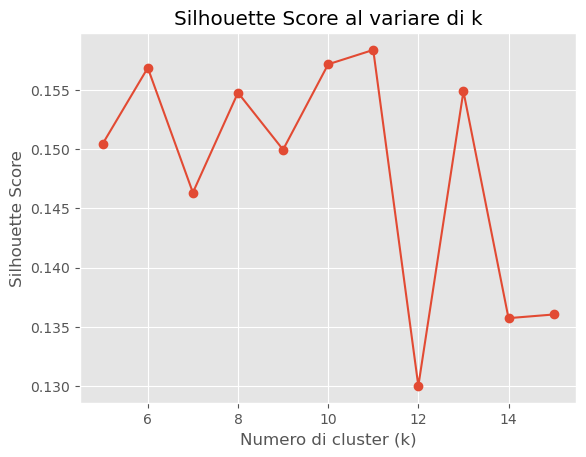

In [131]:
# QUI STO CERCANDO K OTTIMO 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Esecuzione di K-means e calcolo di inertia e silhouette score per valori di k tra 5 e 15
k_values = range(5, 16)
inertia_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_test)
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_test, kmeans.labels_))

# Plotting dell'inertia al variare di k
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Inertia al variare di k')
plt.show()

# Plotting della silhouette score al variare di k
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score al variare di k')
plt.show()

In [142]:
#scelgo k = 6
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(x_test)
centroids = kmeans.cluster_centers_

# shap - come guidotti 
f = lambda x: bb_predict_proba(x)[:, 1]
shap_explainerk = shap.KernelExplainer(f, centroids)

shap_values_singlek = shap_explainerk.shap_values(x, nsamples=1000)
shap_values_singlek

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


array([-2.39243686e-03, -5.90275598e-04, -6.40711102e-03,  2.26549833e-03,
        0.00000000e+00, -1.23256925e-03, -4.32282641e-03,  5.53957446e-03,
        0.00000000e+00, -5.54502637e-03, -2.90372098e-04,  0.00000000e+00,
       -2.08792942e-03, -2.88592815e-03, -2.06326965e-03, -2.77434758e-03,
       -2.02987126e-03, -9.51285616e-03, -7.23781966e-03,  3.38875864e-03,
       -3.10142743e-03,  2.66059435e-03,  3.07776738e-03,  5.24564969e-03,
       -6.75483268e-04, -4.09955268e-04, -1.11468568e-02, -4.60975854e-03,
       -1.84318871e-03, -4.99769170e-04,  2.57308016e-03, -1.78306001e-03,
        0.00000000e+00, -4.11880393e-03, -6.59056177e-03, -2.72009620e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.88848855e-03,
       -2.60722894e-04,  0.00000000e+00,  6.54832628e-03, -2.36675862e-04,
        2.36709590e-03,  0.00000000e+00, -1.80990267e-03, -3.72928049e-03,
       -1.52947606e-03, -2.42323656e-03, -2.74491143e-03,  1.60264643e-03,
        7.86942081e-04,  

In [143]:
shap.force_plot(shap_explainerk.expected_value, shap_values_singlek, features=x, feature_names=feature_names)

<h4>COUNTER FACTUAL</h4>

In [144]:
#!pip install fat-forensics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 547.7 kB/s eta 0:00:00a 0:00:01


In [55]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

24-Jan-25 10:11:13 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [56]:
class_names_mapping = {
    0: 'angry',
    1: 'calm',
    2: 'disgust',
    3: 'fearful',
    4: 'happy',
    5: 'neutral',
    6: 'sad',
    7: 'surprised'
}


In [57]:
#ciclo for abbastanza brutto per vedere qual è il primo record su cui il mio modello compie un errore di classificazione 
#conto inoltre quanti sono quelli di ogni classe che vengono mal classificati
count={'neutral':0,'calm':0,'happy':0,'sad':0,'angry':0,'fearful':0,'disgust':0,'surprised':0}
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        #if y_test[i] == 'happy':
        print(i, 'true:', class_names_mapping[y_test[i]], 'pred:', class_names_mapping[y_pred[i]]) 
        count[class_names_mapping[y_test[i]]]+=1



0 true: neutral pred: sad
3 true: neutral pred: happy
4 true: calm pred: neutral
6 true: calm pred: sad
8 true: calm pred: sad
13 true: happy pred: fearful
16 true: happy pred: fearful
18 true: happy pred: fearful
19 true: happy pred: fearful
20 true: sad pred: neutral
22 true: sad pred: happy
23 true: sad pred: calm
25 true: sad pred: disgust
26 true: sad pred: happy
27 true: sad pred: neutral
28 true: angry pred: fearful
30 true: angry pred: happy
31 true: angry pred: fearful
37 true: fearful pred: sad
39 true: fearful pred: surprised
41 true: fearful pred: angry
47 true: disgust pred: fearful
50 true: disgust pred: angry
51 true: disgust pred: angry
52 true: surprised pred: happy
53 true: surprised pred: happy
54 true: surprised pred: calm
55 true: surprised pred: neutral
56 true: surprised pred: angry
57 true: surprised pred: angry
58 true: surprised pred: happy
59 true: surprised pred: happy
60 true: neutral pred: angry
61 true: neutral pred: angry
64 true: calm pred: neutral
65 t

In [58]:
#in count ho salvato il numero di misclassified di ogni classe. Vedo che quella più misclassified è sad -> cerco di fare explainability su quella
count



{'neutral': 35,
 'calm': 52,
 'happy': 57,
 'sad': 74,
 'angry': 31,
 'fearful': 57,
 'disgust': 26,
 'surprised': 33}

In [ ]:
# quella vera è sad, quella predetta è calm: 23, 82, 86, 125, 185 - 188, 289, 395 - 399
# quella vera è surprised, quella predetta è fearful: 158, 160, 162, 163, 264, 266, 267, 366 - 370

In [59]:
#provo con quelle che sono predette calm ma in realtà sono sad
x1 = x_test[23]
x2 = x_test[82]
x3 = x_test[125]
x4 = x_test[185]
x5 = x_test[289]

class_names = list(bb.classes_)
bb_outcome1 = bb_predict(x1.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
 #bb_outcome_str = class_names[bb_outcome]
bb_outcome2 = bb_predict(x2.reshape(1, -1))[0]
bb_outcome3 = bb_predict(x3.reshape(1, -1))[0]
bb_outcome4 = bb_predict(x4.reshape(1, -1))[0]
bb_outcome5 = bb_predict(x5.reshape(1, -1))[0]


print('bb(x) = { %s }' % class_names_mapping[bb_outcome1], 'true: ', class_names_mapping[y_test[23]] )    
print('bb(x) = { %s }' % class_names_mapping[bb_outcome2], 'true: ', class_names_mapping[y_test[82]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome3], 'true: ', class_names_mapping[y_test[125]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome4], 'true: ', class_names_mapping[y_test[185]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome5], 'true: ', class_names_mapping[y_test[289]])

#questo è come il classificatore va a classificare quelle istanze


bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad


In [ ]:
#NOTA: dalla confusion matrix vedo che quelle che vengono misclassificate più spesso sono: 
    # classe predetta 0 (angry) ma quella vera è 2 (disgust)
    # classe predetta 1 (calm) ma quella vera è 6 (sad)
    # classe predetta 3 (fearful) ma quella vera è 7 (surprised) 


In [163]:
#mi servono gli indici delle feature categoriche: 
df_test #le categoriche sono le ultime 5 -> 236, 235, 234, 233, 232

frame_count       sum       std       q25  q50       q75        kur  \
0         161762  0.475616  0.003693 -0.000092  0.0  0.000153  11.392131   
1         155355  0.120148  0.003508 -0.000122  0.0  0.000153  13.621589   
2         160160 -0.599304  0.003363 -0.000061  0.0  0.000092   7.678162   
3         158558 -0.080383  0.004150 -0.000092  0.0  0.000122  14.511231   
4         176176  0.152222  0.001767 -0.000061  0.0  0.000122   8.944732   
..           ...       ...       ...       ...  ...       ...        ...   
619       219419  0.423157  0.014571 -0.001282  0.0  0.000763   6.520678   
620       217817 -1.375854  0.025596 -0.001190  0.0  0.001007  14.590263   
621       206606  0.573761  0.026421 -0.001770  0.0  0.001038   6.947965   
622       203404  0.792572  0.026456 -0.001709  0.0  0.000977   6.107496   
623       213013  0.355530  0.034206 -0.002228  0.0  0.001190   7.179805   

         skew  lag1_sum  lag1_std  ...  stft_min_w4  stft_q75_w4  stft_q95_w4  \
0   -0.408781 -0.000061  0.000330  ...     0.222808     0.908316          1.0   
1   -0.420177 -0.000305  0.000357  ...     0.114567     0.866973          1.0   
2   -0.751143  0.000183  0.000596  ...     0.010295     0.889984          1.0   
3   -0.868738 -0.000183  0.000619  ...     0.241405     0.904668          1.0   
4   -1.423820 -0.000122  0.000242  ...     0.217860     0.907035          1.0   
..        ...       ...       ...  ...          ...          ...          ...   
619  0.342064  0.000000  0.004814  ...     0.000496     0.834269          1.0   
620  0.535810  0.000061  0.004427  ...     0.002319     0.754146          1.0   
621  0.570335  0.000031  0.005048  ...     0.001602     0.729066          1.0   
622  0.436132  0.000000  0.007719  ...     0.006459     0.798053          1.0   
623  0.319799  0.000000  0.008392  ...     0.007805     0.822547          1.0   

     stft_kur_w4  stft_skew_w4  vocal_channel  emotional_intensity  statement  \
0      -0.260279     -0.566556              1                    0          1   
1      -0.428900     -0.587210              1                    0          1   
2       0.626916     -0.883317              1                    0          0   
3      -0.825144     -0.383701              1                    0          0   
4      -0.536669     -0.547354              1                    0          1   
..           ...           ...            ...                  ...        ...   
619    -0.495689     -0.746055              0                    0          0   
620    -0.877851     -0.152447              0                    1          1   
621    -0.997740     -0.003013              0                    1          1   
622    -0.670500     -0.325276              0                    1          0   
623    -0.538011     -0.613433              0                    1          0   

     repetition  sex  
0             0    1  
1             1    1  
2             0    1  
3             1    1  
4             0    1  
..          ...  ...  
619           1    0  
620           0    0  
621           1    0  
622           0    0  
623           1    0  

[624 rows x 237 columns]

In [83]:
# creo un Counterfactual Explainer

cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=x_test,
    #counterfactual_feature_indices = [232,233,234,235,236],
    categorical_indices=[232,233,234,235,236],          # specifico gli attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=1     #faccio variare solo una feature
)

In [86]:
#X1
dp_1_cf_tuple_c = cf_explainer.explain_instance(x1)
dp_1_cfs_c, dp_1_cfs_distances_c, dp_1_cfs_predictions_c = dp_1_cf_tuple_c

In [87]:
dp_1_cfs_text= fatf_cf.textualise_counterfactuals(
    x1,
    dp_1_cfs_c,
    instance_class=bb_outcome1,
    counterfactuals_distances=dp_1_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_1_cfs_predictions_c.tolist())
)

print(dp_1_cfs_text)

Instance (of class *1*):
[-6.45702897e-01  6.32026257e-02 -8.58861949e-01  5.55897925e-01
 -5.20995887e-02 -6.38323003e-01 -1.87207072e-01 -1.33080805e+00
  3.37343567e-02 -8.33098419e-01  6.21789368e-01 -4.88498226e-01
  3.63208811e-01  6.35404741e-01 -1.61672943e+00 -1.51379708e+00
 -2.29755210e+00  4.48254647e-01  2.28457099e-02  9.36783340e-01
  1.37934152e+00  1.82637231e+00  1.92228076e+00  2.38565149e+00
  1.41732753e+00  1.52560295e+00 -9.11751499e-01  4.14077088e-01
  1.14222822e-01  6.11498248e-01  1.13548326e+00  7.61853937e-01
  2.72275007e-01  5.58452667e-01  1.74520960e-01 -1.33721381e+00
  6.38604348e-01  6.45072822e-01  1.03232519e+00  7.40419174e-01
 -7.88105806e-01 -4.82849817e-01  1.04194137e+00  1.46402849e+00
 -1.72025520e+00  3.23032574e+00  2.01553181e+00  1.70871709e+00
  1.74587699e+00  9.97142409e-01  1.01277812e+00  3.84384993e-02
 -4.90826397e-01  3.53448313e-01  3.89938374e-01  3.23583930e-03
 -4.02564737e-01 -2.93570664e-01  1.52824321e-03  3.35508387e-03


In [91]:
#x2
# creo un Counterfactual Explainer

cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=x_test,
    categorical_indices=[232,233,234,235,236],          # specifico gli attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=1     #faccio variare solo una feature
)

In [97]:
dp_2_cf_tuple_c = cf_explainer.explain_instance(x2)
dp_2_cfs_c, dp_2_cfs_distances_c, dp_2_cfs_predictions_c = dp_2_cf_tuple_c

In [98]:
dp_2_cfs_text= fatf_cf.textualise_counterfactuals(
    x2,
    dp_2_cfs_c,
    instance_class=bb_outcome2,
    counterfactuals_distances=dp_2_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_2_cfs_predictions_c.tolist())
)

print(dp_2_cfs_text)

Instance (of class *1*):
[ 1.66273145 -0.12505853 -0.60512298  0.04906082 -0.05209959  0.67398888
 -0.98670856 -1.16551699  0.22970248 -0.72718725  0.10797689 -0.10939667
 -0.78853031  0.49527022 -0.45059191 -1.11667755 -2.2975521  -0.85507252
  0.32216082  0.35292174 -0.15884986  0.03756609  0.86794783  0.90437116
  0.89711451  1.09785434 -1.14854824  1.54639745  0.87411986 -0.61015889
  0.54025277  0.51792891  0.10065718  0.31532382  0.09783742 -1.1903101
 -1.38580401  0.0690358   0.28230732  0.35674932 -0.31005606  0.65232306
  1.92927381  0.07865051  0.89231061 -0.29584729 -0.36106461 -0.33899727
 -0.35632794  0.72793364 -1.27561601 -0.09563428 -0.08148097  0.07514105
  0.1406766   0.00323584  0.10247166 -0.27017114 -0.70002932  0.01108307
  0.4972742   0.17821009  0.34087257 -0.35757313  0.64464723  0.07930958
  0.64599592  0.23590929 -0.31576687  0.78543125 -0.02982469  0.22175558
  2.19209996  0.85366449  1.39940145  1.6618112   1.10451582  0.20223086
  0.77330837  0.08382619 -0

In [94]:
#x3
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=x_test,
    #categorical_indices=[232,233,234,235,236],          # specifico gli attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=1     #faccio variare solo una feature
)

In [95]:
dp_3_cf_tuple_c = cf_explainer.explain_instance(x3)
dp_3_cfs_c, dp_3_cfs_distances_c, dp_3_cfs_predictions_c = dp_3_cf_tuple_c

In [96]:
dp_3_cfs_text= fatf_cf.textualise_counterfactuals(
    x3,
    dp_3_cfs_c,
    instance_class=bb_outcome3,
    counterfactuals_distances=dp_3_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_3_cfs_predictions_c.tolist())
)

print(dp_3_cfs_text)

Instance (of class *1*):
[-9.27217566e-01 -8.59261280e-03 -9.67009547e-01  6.36991862e-01
 -5.20995887e-02 -7.94021023e-01  1.50745602e-01 -8.50795176e-01
  3.37343567e-02 -9.06201157e-01  7.50242486e-01 -6.78049002e-01
  1.57725504e+00 -8.80761585e-01 -1.37168132e+00 -1.11383632e+00
 -2.29755210e+00 -1.24943257e+00 -3.13764628e+00 -2.66379261e-01
 -4.62105392e-02  8.99278653e-01 -2.47453634e-01 -1.00931200e+00
 -7.41734520e-01 -8.77159934e-01 -5.25480048e-01 -7.50928366e-01
 -1.68335007e+00 -8.26176724e-01  7.38564551e-01 -1.07886969e+00
  8.21297700e-01 -1.22550714e+00 -1.62213967e+00 -4.11046709e+00
 -7.63605506e-01 -1.62523761e-02 -3.15026013e-01 -1.11210153e-01
 -6.08745434e-01 -3.78658308e-01 -1.96212851e+00 -1.06729531e+00
  8.12408039e-01 -4.73983830e-01 -6.11819458e-01 -7.79921292e-01
 -1.42756164e+00 -1.03720420e+00 -5.14172231e-01  7.01316244e-03
 -4.96600365e-01  3.65291175e-01  3.89938374e-01  3.23583930e-03
 -4.02564737e-01 -3.08200963e-01 -5.02046441e-02 -1.79690687e-03


In [146]:
list(df_test.columns)[169]

'sc_std_w3'

In [99]:
#x4
dp_4_cf_tuple_c = cf_explainer.explain_instance(x4)
dp_4_cfs_c, dp_4_cfs_distances_c, dp_4_cfs_predictions_c = dp_4_cf_tuple_c

In [100]:
dp_4_cfs_text= fatf_cf.textualise_counterfactuals(
    x4,
    dp_4_cfs_c,
    instance_class=bb_outcome4,
    counterfactuals_distances=dp_4_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_4_cfs_predictions_c.tolist())
)

print(dp_4_cfs_text)

Instance (of class *1*):
[ 2.05684496e+00 -1.04003183e-01 -6.40938722e-01  3.32889599e-01
 -5.20995887e-02  3.18107695e-01 -1.01509691e+00 -1.20257636e+00
  3.37343567e-02 -6.96039021e-01  1.07976893e-01 -2.98947450e-01
 -2.40013560e-01 -2.71904382e-01 -1.05484600e+00 -1.71686663e+00
 -2.29755210e+00 -3.68348780e+00 -2.53229878e+00 -1.78267991e+00
 -1.47137754e+00 -2.11582392e+00 -1.51726494e+00 -1.23351547e+00
 -1.55847635e+00 -8.58036176e-01 -8.83106905e-01  4.40206543e-01
 -2.83621618e-01 -1.58998375e+00  5.81665178e-01 -1.07886969e+00
  1.02145461e+00 -1.22550714e+00 -1.62213967e+00 -9.53284936e-01
 -1.39443337e+00 -2.04686614e+00  5.45857504e-01  7.52980267e-01
  1.59364553e+00  2.07061411e+00 -1.24655578e+00 -2.21317911e+00
  1.43479195e+00 -4.73983830e-01 -6.11819458e-01 -7.79921292e-01
 -1.40850433e+00 -1.67701265e+00  1.25948805e+00  1.78061290e-01
 -7.23184442e-02 -1.55794757e-01  3.89938374e-01  3.23583930e-03
 -4.02564737e-01 -2.85404749e-01  1.29394326e-01 -2.55532451e-01


In [143]:
list(df_test.columns)[146]

'kur_w3'

In [101]:
#x5
dp_5_cf_tuple_c = cf_explainer.explain_instance(x5)
dp_5_cfs_c, dp_5_cfs_distances_c, dp_5_cfs_predictions_c = dp_5_cf_tuple_c

In [102]:
dp_5_cfs_text= fatf_cf.textualise_counterfactuals(
    x5,
    dp_5_cfs_c,
    instance_class=bb_outcome5,
    counterfactuals_distances=dp_5_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_5_cfs_predictions_c.tolist())
)

print(dp_5_cfs_text)

Instance (of class *1*):
[ 9.87068123e-01  6.08767093e-04 -2.17716689e-01 -5.79417192e-01
 -5.20995887e-02  1.84652248e-01 -9.86878274e-01  2.55281757e-01
  3.37343567e-02 -5.40745006e-01 -1.48929344e-01 -1.09396674e-01
 -7.63577797e-01  1.99599888e+00 -5.02138375e-01 -9.43221125e-01
 -2.29755210e+00 -4.43343716e-01  2.83009514e-01  7.62968196e-01
  1.21150085e+00 -5.56420433e-01 -2.47453634e-01 -6.07793865e-02
  6.11967531e-01  1.75282165e+00 -8.69808602e-01  2.00790328e+00
 -5.61052853e-02 -8.41244342e-01  3.74563157e-01  4.10784132e-01
  2.50392395e-01  2.73064147e-01 -1.60441720e-01 -1.32995422e+00
 -1.39776652e+00 -1.80781736e-01  1.42826954e-01 -1.84926743e-01
 -5.64579873e-02  8.63645803e-01  3.93741572e-01 -5.19747556e-01
  3.03027045e-01 -3.71960243e-01 -8.79539173e-02 -2.30023895e-01
 -5.10577561e-01 -3.37898779e-01 -4.46202944e-01  7.62570592e-03
  1.68343527e-01  1.93569675e-01  1.40676597e-01  3.23583930e-03
 -1.50046538e-01 -2.58686668e-01 -3.60966335e-01  3.30506496e-01


In [ ]:
#Vado a provare una cosa simile con un'altra classe: 
#prendo quelli dove predico fearful mentre invece è surprised (predico 3 e invece è 7)

# 158, 160, 162, 264, 266, 366 - 370, 470

In [ ]:
#Predetta 0 (angry) e invece è 2 (disgust) 50, 252, 361, 460, 466, 569

In [111]:
x6 = x_test[50]
x7 = x_test[252]
x8 = x_test[361]
x9 = x_test[460]
x10 = x_test[569]

class_names = list(bb.classes_)
bb_outcome6 = bb_predict(x6.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
bb_outcome7 = bb_predict(x7.reshape(1, -1))[0]
bb_outcome8 = bb_predict(x8.reshape(1, -1))[0]
bb_outcome9 = bb_predict(x9.reshape(1, -1))[0]
bb_outcome10 = bb_predict(x10.reshape(1, -1))[0]


print('bb(x) = { %s }' % class_names_mapping[bb_outcome6], 'true: ', class_names_mapping[y_test[50]] )    
print('bb(x) = { %s }' % class_names_mapping[bb_outcome7], 'true: ', class_names_mapping[y_test[252]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome8], 'true: ', class_names_mapping[y_test[361]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome9], 'true: ', class_names_mapping[y_test[460]])
print('bb(x) = { %s }' % class_names_mapping[bb_outcome10], 'true: ', class_names_mapping[y_test[569]])

bb(x) = { angry } true:  disgust
bb(x) = { angry } true:  disgust
bb(x) = { angry } true:  disgust
bb(x) = { angry } true:  disgust
bb(x) = { angry } true:  disgust


In [112]:

# creo un Counterfactual Explainer

cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=x_test,
    categorical_indices=[232,233,234,235,236],          # specifico gli attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=1     #faccio variare solo una feature
)

In [113]:
#x6
dp_6_cf_tuple_c = cf_explainer.explain_instance(x6)
dp_6_cfs_c, dp_6_cfs_distances_c, dp_6_cfs_predictions_c = dp_6_cf_tuple_c

In [114]:
dp_6_cfs_text= fatf_cf.textualise_counterfactuals(
    x6,
    dp_6_cfs_c,
    instance_class=bb_outcome6,
    counterfactuals_distances=dp_6_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_6_cfs_predictions_c.tolist())
)

print(dp_6_cfs_text)

Instance (of class *0*):
[ 1.43749862e+00 -1.94359940e-01  8.36493866e-01 -1.28898914e+00
 -5.20995887e-02  2.58685028e+00 -2.77849422e-01  6.00466036e-02
 -1.06368712e+00  1.97681168e+00 -2.46108548e+00  3.87116962e+00
 -8.98748595e-01 -9.23632639e-01  2.30484989e+00  1.33956972e+00
  4.35245843e-01 -1.62762408e-01  9.68053388e-01 -2.11804053e+00
 -1.26651126e+00 -3.37446368e-01 -2.47453634e-01 -2.95729498e-01
 -3.66523788e-01 -1.75953438e+00  3.36471600e+00 -3.06802686e+00
  2.93368240e+00  9.70410680e-01 -8.75170345e-01  1.34810923e+00
  1.91321497e+00  1.31754503e+00  2.14178610e+00  3.38346438e+00
  2.71433435e-01  5.52361876e-02  5.83771451e-01  3.82575447e-01
  5.06283385e-01  4.20937846e-01  1.62723101e+00  3.85190331e-02
  2.46080271e-02 -4.10273473e-01 -4.11040204e-01 -1.63308817e-01
  1.73960171e-03  1.05826060e-01 -5.01853177e-01  1.15098452e+00
  4.08672862e+00 -6.06627115e+00  1.40676597e-01  3.23583930e-03
 -4.02564737e-01 -2.85274248e-01 -5.22744841e-02 -1.20993873e+00


In [115]:
#x7
dp_7_cf_tuple_c = cf_explainer.explain_instance(x7)
dp_7_cfs_c, dp_7_cfs_distances_c, dp_7_cfs_predictions_c = dp_7_cf_tuple_c

In [116]:
dp_7_cfs_text= fatf_cf.textualise_counterfactuals(
    x7,
    dp_7_cfs_c,
    instance_class=bb_outcome7,
    counterfactuals_distances=dp_7_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_7_cfs_predictions_c.tolist())
)

print(dp_7_cfs_text)

Instance (of class *0*):
[-4.20505223e-01 -4.89155453e-03 -2.57829627e-01  4.74803988e-01
 -5.20995887e-02 -6.82808151e-01  1.46714220e+00  1.88336894e+00
  3.37343567e-02 -2.00655108e-01  6.21789368e-01 -4.88498226e-01
  1.43261780e-01  1.95411059e-02 -8.33007292e-01 -7.14197908e-01
  4.35245843e-01  7.02584558e-01  6.39396810e-01  1.22463873e+00
  4.64333483e-01  9.08598234e-01 -2.47453634e-01 -4.16785232e-01
  1.02713858e+00  1.26980010e+00  3.03849269e-01 -8.07187502e-02
  6.83775167e-01  9.06746137e-01  9.88125057e-01  3.59691856e-01
  2.92268278e-01  1.64116115e-01  2.08614654e-01 -2.26356325e-01
  8.43662051e-01  1.29131908e+00  9.21347223e-01  7.35833906e-01
 -7.99450662e-01 -4.88459529e-01  1.14233462e+00  1.30718546e+00
 -1.77958083e+00  2.07346667e+00  1.61563887e+00  2.09033183e+00
  1.45622268e+00  7.66769157e-01  5.22204931e-01  4.60011235e-03
 -4.94783095e-01  3.65291175e-01  3.89938374e-01  3.23583930e-03
 -4.02564737e-01 -2.70145613e-01 -8.61466281e-02 -1.79690687e-03


In [147]:
list(df_test.columns)[157]

'mfcc_min_w3'

In [117]:
#x8
dp_8_cf_tuple_c = cf_explainer.explain_instance(x8)
dp_8_cfs_c, dp_8_cfs_distances_c, dp_8_cfs_predictions_c = dp_8_cf_tuple_c

In [118]:
dp_8_cfs_text= fatf_cf.textualise_counterfactuals(
    x8,
    dp_8_cfs_c,
    instance_class=bb_outcome8,
    counterfactuals_distances=dp_8_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_8_cfs_predictions_c.tolist())
)

print(dp_8_cfs_text)

Instance (of class *0*):
[ 0.19884111 -0.00590695 -0.35436445  0.49507747 -0.05209959 -0.638323
  1.55477769  0.83292693 -0.00545927 -0.41462659  0.49333625 -0.48849823
 -0.26274416  0.77070854  0.53094989  0.41479891  0.43524584 -0.42219377
 -0.39371623 -0.34732108 -0.97865099 -0.09347919 -0.24745363 -0.8548824
 -0.64760503 -0.11261084 -0.18254991 -0.09868274  1.64911025  1.09617348
  0.58757348  0.84459148  0.25711817  0.83851083  0.51786779  0.43821529
  1.05697174  0.95466644  0.77655463  0.59134092 -0.75050383 -0.80175809
  0.69114515  0.30450282 -0.13748377  0.1874243   0.0631454  -0.03809834
  0.18094747  0.29756576 -0.55515065  0.04161259 -0.33180148  0.35344831
  0.38993837  0.00323584 -0.40256474 -0.09333222  0.35734932 -0.29159639
 -0.00176459  0.39866861  0.34087257 -0.2519519   0.0172994   0.88685202
  0.64599592  0.23590929 -0.33254638 -0.12719693  0.23159094 -0.40794479
 -0.64468041 -1.27385703  0.09533833  0.03411849  0.34694041  0.42695983
 -0.33819763 -0.05224549 -0.1

In [148]:
list(df_test.columns)[102]

'stft_kur_w1'

In [119]:
#x9
dp_9_cf_tuple_c = cf_explainer.explain_instance(x9)
dp_9_cfs_c, dp_9_cfs_distances_c, dp_9_cfs_predictions_c = dp_9_cf_tuple_c

In [120]:
dp_9_cfs_text= fatf_cf.textualise_counterfactuals(
    x9,
    dp_9_cfs_c,
    instance_class=bb_outcome9,
    counterfactuals_distances=dp_9_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_9_cfs_predictions_c.tolist())
)

print(dp_9_cfs_text)

Instance (of class *0*):
[-8.14618730e-01  1.26281109e-02 -6.68111613e-01  6.16718378e-01
 -5.20995887e-02 -7.71778449e-01  8.67176169e-01  2.17118219e+00
  3.37343567e-02 -4.87732779e-01  6.21789368e-01 -4.88498226e-01
  1.83409600e+00  1.17771921e-01 -5.65289539e-01 -2.02075851e-01
  4.35245843e-01  3.75694661e-01 -2.96127350e-01  1.00401063e+00
 -1.40781279e+00  1.28215257e+00 -2.47453634e-01  2.75554408e-01
  2.39435614e-02  3.89376050e-01  4.62141027e-01 -1.12781460e+00
  5.53614612e-01  1.22303099e+00  7.57756866e-01 -1.07886969e+00
  5.87086539e-01 -1.22550714e+00 -1.52568813e-01  8.81854573e-01
  1.35916538e+00  2.81156966e-01  1.26115232e+00  8.37054121e-01
 -1.55870090e-01 -9.12095786e-01  1.84744799e-01  8.73268353e-01
 -1.40750937e+00 -4.73983830e-01 -6.11819458e-01  7.90336190e-01
  1.14729879e+00  4.07042502e-01  7.43061171e-01  1.35655215e-02
 -4.94860989e-01  3.65291175e-01  3.89938374e-01  3.23583930e-03
 -4.02564737e-01 -2.64862051e-01  2.11089412e-01 -1.79690687e-03


In [149]:
list(df_test.columns)[60]

'lag1_min_w1'

In [121]:
#x10
dp_10_cf_tuple_c = cf_explainer.explain_instance(x10)
dp_10_cfs_c, dp_10_cfs_distances_c, dp_10_cfs_predictions_c = dp_10_cf_tuple_c

In [122]:
dp_10_cfs_text= fatf_cf.textualise_counterfactuals(
    x10,
    dp_10_cfs_c,
    instance_class=bb_outcome10,
    counterfactuals_distances=dp_10_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_10_cfs_predictions_c.tolist())
)

print(dp_10_cfs_text)

Instance (of class *0*):
[ 0.98706812 -0.02578815 -0.0117801  -0.07258009 -0.05209959  0.1401671
 -0.01533455  0.57422009  0.03373436  0.25764827 -0.27738246  0.64880643
  0.61316708 -1.3193882   2.06816796  1.41124465  0.43524584 -0.84089915
 -0.21904416 -0.58784104 -1.25838722 -0.84366528 -0.91201386 -1.01647096
 -1.19504243 -0.841099    0.85970599 -0.81473694  1.10130423  0.01080548
 -0.8469041  -1.07886969  0.25493929 -1.22550714  0.75906618  1.05077627
  0.26305497 -0.39867575 -0.49254624 -0.96704215  0.24697706 -0.27764659
 -0.04666364 -0.83984191 -0.20751008 -0.47398383 -0.61181946 -0.61116112
 -0.57647972 -1.40418143  0.69319314 -0.78550673  0.63476989 -0.28014481
  0.1406766   0.00323584 -0.15004654 -0.22932264  0.35562733 -0.0043729
 -1.35295265 -1.36499955 -0.32175135 -0.35294065 -0.24103343  1.21047389
  0.64599592  0.23590929 -0.139215    0.54806217 -1.38582734  1.57863409
  0.44200781 -0.57570603 -1.47467195 -0.8345209  -0.7816714  -0.63998296
 -0.39169619  0.50485525 -0.

In [150]:
list(df_test.columns)[79]

'mfcc_kur_w1'